In [4]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import scipy.optimize
import scipy.signal
from scipy.ndimage import convolve
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [5]:
class PhotonTransfer(object):
    '''A class for creating photon transfer curves.'''

    def __init__(self, dir, bits=16, gain_setting=None, flux=1):
        '''Initialize a photon transfer object.
        
        Parameters
        ----------
        dir : str
            The directory containing two subdirectories: one titled Dark Images
            and one titled Gray Images. Within these subdirectories, the name of
            each image should start with the exposure time in milliseconds,
            e.g. '0.1ms_1.fits'. Image files may be in .fits format.
            For each exposure time, there should be at least two dark
            images and two gray images. By default, it uses only the first two
            images for each exposure time.
        bits : int
            The number of bits used to represent each pixel. Default is 16.
        gain_setting : int
            The gain setting of the camera, in dB. Default is None.
        flux : float
            The flux of the light source, in phot/s/pix. Default is 1.
            Get from photodiode set point or measurement.
        '''

        self.dir = dir
        self.bits = bits
        self.gain_setting = gain_setting
        self.dark_dir = dir + '/Dark Images'
        self.gray_dir = dir + '/Gray Images'
        self.dark_files = os.listdir(self.dark_dir)
        self.gray_files = os.listdir(self.gray_dir)
        self.exposure_times = self.get_exposure_times()
        self.irradiation_list = flux * np.array(self.exposure_times).astype(float) / 1000
        self.gray_mean_list = np.zeros(len(self.exposure_times))
        self.gray_temp_var_list = np.zeros(len(self.exposure_times))
        self.dark_mean_list = np.zeros(len(self.exposure_times))
        self.dark_temp_var_list = np.zeros(len(self.exposure_times))
        for i, time in enumerate(self.exposure_times):
            results = self.mean_and_var(time)
            self.gray_mean_list[i] = results[0]
            self.gray_temp_var_list[i] = results[1]
            self.dark_mean_list[i] = results[2]
            self.dark_temp_var_list[i] = results[3]
        self.saturation_ADU = self.get_saturation_ADU()
        (self.gain, self.gain_err) = self.get_gain()
        self.read_noise = self.get_read_noise()

    def get_img_array(self, file):
        '''Returns a numpy array of the image data.'''
        if file.endswith('.fits'):
            return fits.getdata(file).astype(int)

        else:
            raise ValueError('File must be in .fits format')

    def get_exposure_times(self):
        '''Returns a list of the exposure times in milliseconds.'''
        dark_times = []
        gray_times = []
        for file in self.gray_files:
            if file.endswith('.fits'):
                gray_times.append(file.split('ms')[0])
        for file in self.dark_files:
            if file.endswith('.fits'):
                dark_times.append(file.split('ms')[0])
        # Only keep times for which there are at least two dark images
        # and two gray images
        exposure_times = [time for time in dark_times if
                          (dark_times.count(time) >= 2 and
                           gray_times.count(time) >= 2)]
        # Drop duplicates
        exposure_times = list(set(exposure_times))
        # Sort the strings according to their numerical value
        return(sorted(exposure_times, key=lambda x: float(x)))

    def mean_and_var(self, exposure_time):
        dark_files = [file for file in self.dark_files if
                      file.startswith(exposure_time + 'ms') and file.endswith('.fits')]
        gray_files = [file for file in self.gray_files if
                      file.startswith(exposure_time + 'ms') and file.endswith('.fits')]
        gray_image_0 = self.get_img_array(self.gray_dir + '/' + gray_files[0])
        gray_image_1 = self.get_img_array(self.gray_dir + '/' + gray_files[1])
        dark_image_0 = self.get_img_array(self.dark_dir + '/' + dark_files[0])
        dark_image_1 = self.get_img_array(self.dark_dir + '/' + dark_files[1])
        gray_mean = np.mean(gray_image_0 + gray_image_1) / 2
        dark_mean = np.mean(dark_image_0 + dark_image_1) / 2
        gray_temporal_var = np.mean((gray_image_0 - gray_image_1) ** 2) / 2
        dark_temporal_var = np.mean((dark_image_0 - dark_image_1) ** 2) / 2
        return [gray_mean, gray_temporal_var, dark_mean, dark_temporal_var]
    
    def get_read_noise(self):
        '''Returns the read noise in ADU.'''
        dark_temporal_var_adu = self.dark_temp_var_list[0]
        quantization_var = 1.0 / 12.0
        # Assumes the dark temporal variance is dominated by read noise
        # This is not true if it is less than 0.24 ADU
        if dark_temporal_var_adu > 0.24:
            read_noise_e = np.sqrt(dark_temporal_var_adu - quantization_var) / self.gain
        else:
            read_noise_e = 0.4 / self.gain
        return read_noise_e
    
    def get_saturation_ADU(self):
        '''Returns mean gray level in ADU at which less than 0.2% of pixels saturate.'''
        # Approximating the noise as Gaussian, no more than 0.2% of pixels
        # will saturate if the mean gray level is more than 3 times the noise
        # level below saturation. Disregard dark noise; only consider photon shot noise.
        max_value = 2 ** self.bits - 1
        satuartion_ADU = (9 + 2 * max_value) / 2 - 3 * np.sqrt(9 + 4 * max_value) / 2
        return int(satuartion_ADU)

    def get_linearity_fit(self):
        '''Fit irradiation vs. mean gray value to a line using weighted least squares.'''
        # See EMVA 1288 standard section 6.9 for details
        # Use values between 5% and 95% of saturation
        gray_vals_fit = self.gray_mean_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                            (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        rad_vals_fit = self.irradiation_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                             (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        def func(params):
            a0, a1 = params
            return np.sum((gray_vals_fit - (a0 + a1 * rad_vals_fit)) ** 2 / gray_vals_fit ** 2)
        # find a0, a1 that minimize func
        linearity_fit = scipy.optimize.minimize(func, [0, 1]).x
        return linearity_fit
    
    def get_gain(self):
        '''Returns the best fit gain, and std. error of this gain, in ADU/e-.'''
        x = self.gray_mean_list - self.dark_mean_list
        y = self.gray_temp_var_list - self.dark_temp_var_list
        x = x[self.gray_mean_list < 0.7 * self.saturation_ADU]
        y = y[self.gray_mean_list < 0.7 * self.saturation_ADU]
        # Fit up to 70% of max ADU to a line
        popt, pcov = scipy.optimize.curve_fit(lambda x, a: a * x, x, y)
        gain = popt[0]
        gain_err = np.sqrt(pcov[0][0])
        return gain, gain_err

    def plot_phot_transfer(self):
        '''Plots the photon transfer curve.'''
        x = self.gray_mean_list - self.dark_mean_list
        y = self.gray_temp_var_list - self.dark_temp_var_list
        max_x = 2 ** self.bits
        plt.plot(x, y, 'o', label='Temporal Variance')
        plt.plot(x[x < 0.7 * max_x], self.gain * x[x < 0.7 * max_x], label='Fit')
        if self.gain_setting is not None:
            plt.text(0.05 * np.max(x), 0.95 * max(y), 'Gain Setting: '
                     + str(self.gain_setting) + ' dB')
        plt.text(0.05 * np.max(x), 0.90 * max(y), 'Gain: ' + format(self.gain, '.3f')
                 + r'$\pm$' + format(self.gain_err, '.3f') + ' ADU/e-')
        plt.text(0.05 * np.max(x), 0.85 * max(y), 'Read Noise: ' + format(self.read_noise, '.2f')
                 + ' e-')
        plt.xlabel(r'$\mu_{gray} - \mu_{dark}$ (ADU)')
        plt.ylabel(r'$\sigma_{gray}^2 - \sigma_{dark}^2$ (ADU$^2$)')
        plt.gca().xaxis.label.set_fontsize(14)
        plt.gca().yaxis.label.set_fontsize(14)
        plt.title('Photon Transfer Curve')
        plt.show()

    def plot_linearity(self):
        '''Plot irradiation vs. mean gray value, alongside residuals.'''
        gray_vals_fit = self.gray_mean_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                            (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        rad_vals_fit = self.irradiation_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                             (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        [a0, a1] = self.get_linearity_fit()
        saturation_phot = (self.saturation_ADU - a0) / a1
        x = self.irradiation_list
        y = self.gray_mean_list
        x_fit = np.linspace(rad_vals_fit[0], rad_vals_fit[-1], 100)
        y_fit = a0 + a1 * x_fit
        residuals = (gray_vals_fit - (a0 + a1 * rad_vals_fit)) / (a0 + a1 * rad_vals_fit) * 100
        linearity_error = np.mean(np.abs(residuals))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        # Make it wider
        fig.set_size_inches(12, 6)
        ax1.plot(x, y, 'o', label='Measured')
        ax1.plot(x_fit, y_fit, label='Fit')
        ax1.legend()
        ax1.axvline(x=0.05 * saturation_phot, color='gray', linestyle='--')
        ax1.axvline(x=0.95 * saturation_phot, color='gray', linestyle='--')
        ax1.axvline(x=saturation_phot, color='black', linestyle='-')
        ax1.set_xlabel('Irradiation (photons/pixel)')
        ax1.set_ylabel(r'$\mu_{gray}$ (ADU)')
        ax2.plot(rad_vals_fit, residuals, 'o')
        ax2.axvline(x=0.05 * saturation_phot, color='gray', linestyle='--')
        ax2.axvline(x=0.95 * saturation_phot, color='gray', linestyle='--')
        ax2.axvline(x=saturation_phot, color='black', linestyle='-')
        # Put text: max residual, min residual, linearity error
        ax2.text(0.1 * saturation_phot, 0.3 * max(residuals), 'Max Residual: '
                 + format(np.max(residuals), '.2f') + '%')
        ax2.text(0.1 * saturation_phot, 0.2 * max(residuals), 'Min Residual: '
                 + format(np.min(residuals), '.2f') + '%')
        ax2.text(0.1 * saturation_phot, 0.1 * max(residuals), 'Linearity Error: '
                 + format(linearity_error, '.2f') + '%')
        ax2.set_xlabel('Irradiation (photons/pixel)')
        ax2.set_ylabel('Linearity Error (%)')
        ax1.xaxis.label.set_fontsize(14)
        ax1.yaxis.label.set_fontsize(14)
        ax2.xaxis.label.set_fontsize(14)
        ax2.yaxis.label.set_fontsize(14)
        plt.subplots_adjust(wspace=0.3)
        plt.show()


In [6]:
class PhotonTransferCOSMOS(object):
    '''A class for creating photon transfer curves.'''

    def __init__(self, dir, bits=16, gain_setting=None, flux=1):
        '''Initialize a photon transfer object.
        
        Parameters
        ----------
        dir : str
            The directory containing two subdirectories: one titled Dark Images
            and one titled Gray Images. Within these subdirectories, the name of
            each image should start with the exposure time in milliseconds,
            e.g. '0.1ms_1.fits'. Image files may be in .fits format.
            For each exposure time, there should be at least two dark
            images and two gray images. By default, it uses only the first two
            images for each exposure time.
        bits : int
            The number of bits used to represent each pixel. Default is 16.
        gain_setting : int
            The gain setting of the camera, in dB. Default is None.
        flux : float
            The flux of the light source, in phot/s/pix. Default is 1.
            Get from photodiode set point or measurement.
        '''

        self.dir = dir
        self.bits = bits
        self.gain_setting = gain_setting
        self.dark_files = []
        self.gray_files = []
        self.exposure_times = []
        self.sort_files()
        self.irradiation_list = flux * np.array(self.exposure_times).astype(float) / 1000
        self.gray_mean_list = np.zeros(len(self.exposure_times))
        self.gray_temp_var_list = np.zeros(len(self.exposure_times))
        self.dark_mean_list = np.zeros(len(self.exposure_times))
        self.dark_temp_var_list = np.zeros(len(self.exposure_times))
        for i, time in enumerate(self.exposure_times):
            results = self.mean_and_var(time)
            self.gray_mean_list[i] = results[0]
            self.gray_temp_var_list[i] = results[1]
            self.dark_mean_list[i] = results[2]
            self.dark_temp_var_list[i] = results[3]
        self.saturation_ADU = self.get_saturation_ADU()
        (self.gain, self.gain_err) = self.get_gain()
        self.read_noise = self.get_read_noise()

    def sort_files(self):
        all_files = os.listdir(self.dir)
        dark_times = []
        gray_times = []
        for file in all_files:
            # if file.endswith('.fits') and file.startswith('HighHighG_RS') and 'ms' in file:
            if file.endswith('.fits') and file.startswith('HighSLowG_RS') and 'ms' in file:
                if 'SC' in file:
                    self.dark_files.append(file)
                    dark_time = file.split('ms')[0].split('_')[-1]
                    dark_times.append(dark_time)
                elif 'SO' in file:
                    self.gray_files.append(file)
                    gray_time = file.split('ms')[0].split('_')[-1]
                    gray_times.append(gray_time)
        exposure_times = [time for time in dark_times if
                          (dark_times.count(time) >= 1 and
                           gray_times.count(time) >= 1)]
        self.exposure_times = exposure_times

    def get_img_array(self, file, frame_num):
        '''Returns a numpy array of the image data.'''
        if file.endswith('.fits'):
            return fits.getdata(file)[frame_num].astype(int)

        else:
            raise ValueError('File must be in .fits format')

    def mean_and_var(self, exposure_time):
        search_str = '_' + exposure_time + 'ms'
        dark_files = [file for file in self.dark_files if  search_str in file]
        gray_files = [file for file in self.gray_files if search_str in file]
        dark_image_0 = fits.getdata(self.dir + '/' + dark_files[0])[0].astype(int)
        dark_image_1 = fits.getdata(self.dir + '/' + dark_files[0])[1].astype(int)
        gray_image_0 = fits.getdata(self.dir + '/' + gray_files[0])[0].astype(int)
        gray_image_1 = fits.getdata(self.dir + '/' + gray_files[0])[1].astype(int)
        gray_mean = np.mean(gray_image_0 + gray_image_1) / 2
        dark_mean = np.mean(dark_image_0 + dark_image_1) / 2
        gray_temporal_var = np.mean((gray_image_0 - gray_image_1) ** 2) / 2
        dark_temporal_var = np.mean((dark_image_0 - dark_image_1) ** 2) / 2
        print(exposure_time, gray_mean)
        return [gray_mean, gray_temporal_var, dark_mean, dark_temporal_var]
    
    def get_read_noise(self):
        '''Returns the read noise in ADU.'''
        dark_temporal_var_adu = self.dark_temp_var_list[0]
        quantization_var = 1.0 / 12.0
        # Assumes the dark temporal variance is dominated by read noise
        # This is not true if it is less than 0.24 ADU
        if dark_temporal_var_adu > 0.24:
            read_noise_e = np.sqrt(dark_temporal_var_adu - quantization_var) / self.gain
        else:
            read_noise_e = 0.4 / self.gain
        return read_noise_e
    
    def get_saturation_ADU(self):
        '''Returns mean gray level in ADU at which less than 0.2% of pixels saturate.'''
        # Approximating the noise as Gaussian, no more than 0.2% of pixels
        # will saturate if the mean gray level is more than 3 times the noise
        # level below saturation. Disregard dark noise; only consider photon shot noise.
        max_value = 2 ** self.bits - 1
        satuartion_ADU = (9 + 2 * max_value) / 2 - 3 * np.sqrt(9 + 4 * max_value) / 2
        return int(satuartion_ADU)

    def get_linearity_fit(self):
        '''Fit irradiation vs. mean gray value to a line using weighted least squares.'''
        # See EMVA 1288 standard section 6.9 for details
        # Use values between 5% and 95% of saturation
        gray_vals_fit = self.gray_mean_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                            (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        rad_vals_fit = self.irradiation_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                             (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        def func(params):
            a0, a1 = params
            return np.sum((gray_vals_fit - (a0 + a1 * rad_vals_fit)) ** 2 / gray_vals_fit ** 2)
        # find a0, a1 that minimize func
        linearity_fit = scipy.optimize.minimize(func, [0, 1]).x
        return linearity_fit
    
    def get_gain(self):
        '''Returns the best fit gain, and std. error of this gain, in ADU/e-.'''
        x = self.gray_mean_list - self.dark_mean_list
        y = self.gray_temp_var_list - self.dark_temp_var_list
        x = x[self.gray_mean_list < 5500]
        y = y[self.gray_mean_list < 5500]
        # Fit up to 70% of max ADU to a line
        popt, pcov = scipy.optimize.curve_fit(lambda x, a: a * x, x, y)
        gain = popt[0]
        gain_err = np.sqrt(pcov[0][0])
        return gain, gain_err

    def plot_phot_transfer(self):
        '''Plots the photon transfer curve.'''
        x = self.gray_mean_list - self.dark_mean_list
        y = self.gray_temp_var_list - self.dark_temp_var_list
        max_x = 2 ** self.bits
        print(x)
        print(y)
        plt.plot(x, y, 'o', label='Temporal Variance')
        plt.plot(x[x < 0.7 * max_x], self.gain * x[x < 5500], label='Fit')
        if self.gain_setting is not None:
            plt.text(0.05 * np.max(x), 0.95 * max(y), 'Gain Setting: '
                     + str(self.gain_setting) + ' dB')
        plt.text(0.05 * np.max(x), 0.90 * max(y), 'Gain: ' + format(self.gain, '.3f')
                 + r'$\pm$' + format(self.gain_err, '.3f') + ' ADU/e-')
        plt.text(0.05 * np.max(x), 0.85 * max(y), 'Read Noise: ' + format(self.read_noise, '.2f')
                 + ' e-')
        plt.xlabel(r'$\mu_{gray} - \mu_{dark}$ (ADU)')
        plt.ylabel(r'$\sigma_{gray}^2 - \sigma_{dark}^2$ (ADU$^2$)')
        plt.gca().xaxis.label.set_fontsize(14)
        plt.gca().yaxis.label.set_fontsize(14)
        plt.title('Photon Transfer Curve')
        plt.show()

    def plot_linearity(self):
        '''Plot irradiation vs. mean gray value, alongside residuals.'''
        gray_vals_fit = self.gray_mean_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                            (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        rad_vals_fit = self.irradiation_list[(self.gray_mean_list < 0.95 * self.saturation_ADU) &
                                             (self.gray_mean_list > 0.05 * self.saturation_ADU)]
        [a0, a1] = self.get_linearity_fit()
        saturation_phot = (self.saturation_ADU - a0) / a1
        x = self.irradiation_list
        y = self.gray_mean_list
        x_fit = np.linspace(rad_vals_fit[0], rad_vals_fit[-1], 100)
        y_fit = a0 + a1 * x_fit
        residuals = (gray_vals_fit - (a0 + a1 * rad_vals_fit)) / (a0 + a1 * rad_vals_fit) * 100
        linearity_error = np.mean(np.abs(residuals))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        # Make it wider
        fig.set_size_inches(12, 6)
        ax1.plot(x, y, 'o', label='Measured')
        ax1.plot(x_fit, y_fit, label='Fit')
        ax1.legend()
        ax1.axvline(x=0.05 * saturation_phot, color='gray', linestyle='--')
        ax1.axvline(x=0.95 * saturation_phot, color='gray', linestyle='--')
        ax1.axvline(x=saturation_phot, color='black', linestyle='-')
        ax1.set_xlabel('Irradiation (photons/pixel)')
        ax1.set_ylabel(r'$\mu_{gray}$ (ADU)')
        ax2.plot(rad_vals_fit, residuals, 'o')
        ax2.axvline(x=0.05 * saturation_phot, color='gray', linestyle='--')
        ax2.axvline(x=0.95 * saturation_phot, color='gray', linestyle='--')
        ax2.axvline(x=saturation_phot, color='black', linestyle='-')
        # Put text: max residual, min residual, linearity error
        ax2.text(0.1 * saturation_phot, 0.3 * max(residuals), 'Max Residual: '
                 + format(np.max(residuals), '.2f') + '%')
        ax2.text(0.1 * saturation_phot, 0.2 * max(residuals), 'Min Residual: '
                 + format(np.min(residuals), '.2f') + '%')
        ax2.text(0.1 * saturation_phot, 0.1 * max(residuals), 'Linearity Error: '
                 + format(linearity_error, '.2f') + '%')
        ax2.set_xlabel('Irradiation (photons/pixel)')
        ax2.set_ylabel('Linearity Error (%)')
        ax1.xaxis.label.set_fontsize(14)
        ax1.yaxis.label.set_fontsize(14)
        ax2.xaxis.label.set_fontsize(14)
        ax2.yaxis.label.set_fontsize(14)
        plt.subplots_adjust(wspace=0.3)
        plt.show()

In [7]:
# dir24 = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX487/Photon Transfer/Gain 24 dB'
# photTransfer24 = PhotonTransfer(dir24, bits=12, gain_setting=24, flux=338.4)
# dirIMX455 = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX455/Photon Transfer'
# photTransferIMX455 = PhotonTransfer(dirIMX455, bits=16, gain_setting=0, flux=631.4)
dirCOSMOS = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab Data/05-02-2024'
# file1 = 'HighHighG_RS_raw_1000ms_SO 2024 May 03 11_05_14.fits'
# file1 = 'HighHighG_RS_raw_1600ms_SC 2024 May 03 11_06_37.fits'
# file1data = fits.getdata(dirCOSMOS + '/' + file1)[0].astype(int)
# file2data = fits.getdata(dirCOSMOS + '/' + file1)[1].astype(int)
# print(np.mean((file2data + file1data)) / 2)
# print(np.mean((file2data - file1data) ** 2) / 2)
cosmosPTC = PhotonTransferCOSMOS(dirCOSMOS, bits=14)
# # For fits files in the directory that start with XXXs instead of XXXms, reformat their name by multiplying by 1000
# for file in os.listdir(dirIMX455 + '/Gray Images'):
#     if file.endswith('.fits'):
#         if file.split('s')[0][-1] != 'm':
#             new_name = str(int(float(file.split('s')[0]) * 1000)) + 'ms' + file.split('s')[1]
#             print(new_name)
#             os.rename(dirIMX455 + '/Gray Images/' + file, dirIMX455 + '/Gray Images/' + new_name)
#     elif file.endswith('.fit'):
#         # screwed up, so add the s back at the end of fits
#         os.rename(dirIMX455 + '/Gray Images/' + file, dirIMX455 + '/Gray Images/' + file + 's')

1000 1115.3503486192337
4000 3077.0157957075517
10000 7068.39920786418
25000 15543.687451717162
15000 10360.899868338834
3200 2551.9384633211193
3600 2817.0433492380307
25000 15543.687451717162
400 736.4355960621466
1200 1248.4969255729939
20000 13460.495334483972
100 542.1291676878838
2400 2026.0350335712467
20000 13460.495334483972
6000 4405.214932804423
15000 10360.899868338834
1600 1508.1998464306948
800 987.9090336152296
200 609.3166007349729
600 861.7343594239122


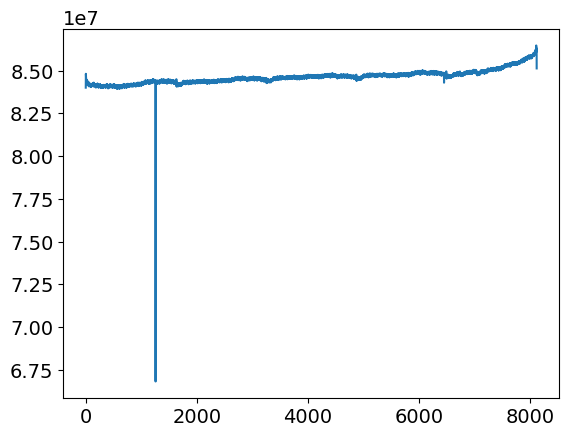

In [8]:
dirCOSMOS = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/Teledyne_COSMOS/MKI Lab Data/05-07-2024/QE Filters1_9A'
file1 = 'HighSHighG_GS_raw_2000ms_SO_F1A 2024 May 07 11_05_30.fits'
file2 = 'HighSHighG_GS_raw_2000ms_SC_F1A 2024 May 07 11_05_13.fits'
file1data = fits.getdata(dirCOSMOS + '/' + file1)[0].astype(int)
file2data = fits.getdata(dirCOSMOS + '/' + file2)[0].astype(int)
imgdata = file1data - file2data
plt.plot(imgdata.sum(axis=1))
# plt.ylim(8.4E7, 8.6E7)

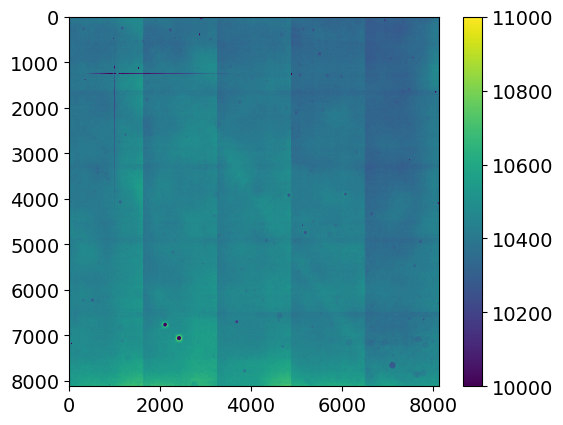

In [9]:
plt.imshow(imgdata)
plt.clim(10000, 11000)
plt.colorbar()

[  610.67625181  2572.19827738  6563.47873349 15038.53583584
  9855.77778199  2047.03290747  2312.17401795 15038.53583584
   231.66251263   743.79557876 12955.34827106    37.16628448
  1521.22662538 12955.34827106  3900.28997557  9855.77778199
  1003.41557959   483.17517919   104.47664507   356.93509547]
[ 92.25532659 347.35571501 760.99858349 144.09020362 954.52421395
 271.17856026 315.36613522 144.09020362  37.9174173  108.43742282
 529.1427978   11.3201831  209.34027807 529.1427978  499.38764258
 954.52421395 138.95385128  67.27149559  15.88187196  57.58056584]


ValueError: x and y must have same first dimension, but have shapes (16,) and (13,)

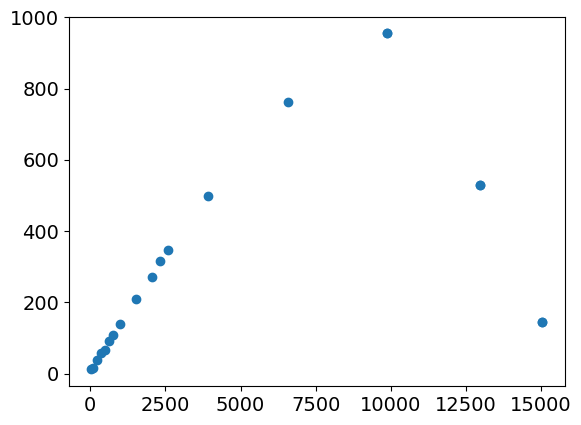

In [10]:
cosmosPTC.plot_phot_transfer()
cosmosPTC.plot_linearity()

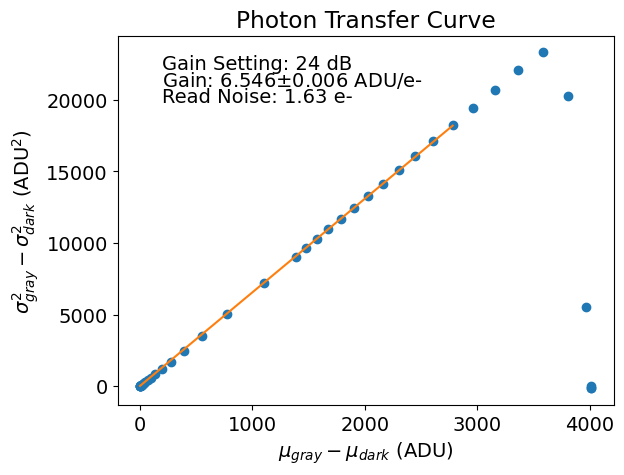

In [ ]:
photTransfer24.plot_phot_transfer()

In [ ]:
def highpass_filter(img, dim=5):
    '''Returns the image, highpass filtered.'''
    box_filter = np.ones((dim, dim)) / dim ** 2
    box_img = convolve(img, box_filter)
    filtered_img = img - box_img
    # Remove 2 rows and 2 columns from each side
    return filtered_img[2:-2, 2:-2]

class GrayNonuniformity(object):
    '''A class for calculating the pixel nonuniformity of a sensor.'''

    def __init__(self, dir, gain=1):
        '''Initialize an ImageSequence object

        Parameters
        ----------
        dir : str
            The directory containing the images. All images must be .fits files.
            Recommended at least 16 images, but preferably >100, to beat down
            temporal noise.
        gain : float
            The gain of the camera, in ADU/e-. Default is 1.
        '''
        
        self.dir = dir
        self.gain = gain
        self.dark_dir = dir + '/Dark Images'
        self.gray_dir = dir + '/Gray Images'
        self.dark_files = os.listdir(self.dark_dir)
        self.gray_files = os.listdir(self.gray_dir)
        # Only use .fits files; exclude hidden files that SAOImage generates
        self.dark_files = [file for file in self.dark_files if file.endswith('.fits')
                           and not file.startswith('.')]
        self.gray_files = [file for file in self.gray_files if file.endswith('.fits')
                            and not file.startswith('.')]
        self.gray_num_img = len(self.gray_files)
        self.dark_num_img = len(self.dark_files)
        self.img_shape = fits.getdata(self.gray_dir + '/' + self.gray_files[0]).shape
        self.M = self.img_shape[0]
        self.N = self.img_shape[1]
        # Filter the mean images
        self.gray_avg_img = self.get_avg_img()
        self.dark_avg_img = self.get_avg_img(is_dark=True)
        # y image has no filtering and is used for plotting profiles, which can
        # reveal the nonuniform illumination of the sensor.
        self.y_img = self.get_avg_img() - self.get_avg_img(is_dark=True)
        self.gray_var_img = self.get_var_img()
        self.dark_var_img = self.get_var_img(is_dark=True)
        self.prnu = self.get_PRNU()

    def get_avg_img(self, is_dark=False):
        '''Returns the average image of the sequence'''
        if is_dark:
            img_files = self.dark_files
            dir = self.dark_dir
        else:
            img_files = self.gray_files
            dir = self.gray_dir
        avg_img = np.zeros(self.img_shape)
        for img_file in img_files:
            img = fits.getdata(dir + '/' + img_file).astype(float)
            avg_img += img
        avg_img /= len(img_files)
        return avg_img

    def get_var_img(self, is_dark=False):
        '''Returns the temporal variance of the sequence'''
        if is_dark:
            img_files = self.dark_files
            dir = self.dark_dir
            avg_img = self.dark_avg_img
        else:
            img_files = self.gray_files
            dir = self.gray_dir
            avg_img = self.gray_avg_img
        var_img = np.zeros(self.img_shape)
        for img_file in img_files:
            img = fits.getdata(dir + '/' + img_file).astype(float)
            var_img += (img - avg_img) ** 2
        return var_img / (len(img_files) - 1)

    def get_PRNU(self):
        '''Returns the pixel response non-uniformity, in percent.'''
        gray_temporal_var = np.mean(self.gray_var_img)
        gray_meas_var = np.var(self.gray_avg_img)
        gray_spatial_var = gray_meas_var - gray_temporal_var / self.gray_num_img
        dark_temporal_var = np.mean(self.dark_var_img)
        dark_meas_var = np.var(self.dark_avg_img)
        dark_spatial_var = dark_meas_var - dark_temporal_var / self.dark_num_img
        return 100 * (np.sqrt(gray_spatial_var - dark_spatial_var)) / np.mean(self.y_img)
    
    # def power_spect(self, is_dark=False, is_vertical=False):
    #     '''Returns the power spectrum of the image sequence averaged over all rows or columns.'''
    #     if is_vertical:
    #         spect_axis = 0
    #     else:
    #         spect_axis = 1
    #     avg_img = self.get_avg_img(is_dark=is_dark)
    #     avg = np.mean(avg_img)
    #     temporal_var = np.mean(self.get_var_img(is_dark=True)) / (self.gray_num_img - 1)
    #     diff_img = avg_img - avg
    #     fourier_trans = np.fft.fft(diff_img, axis=spect_axis) / np.sqrt(self.img_shape[1])
    #     pow_spect = np.mean(np.absolute(fourier_trans) ** 2, axis=0)
    #     pow_spect -= temporal_var / self.gray_num_img
    #     # Only go to the Nyguist frequency
    #     pow_spect = pow_spect[:self.N//2]
    #     return pow_spect
    
    # def plot_spectrograms(self, is_dark=False):
    #     '''Plot both spectrograms on one figure with two separate axes'''
    #     pow_spect_horiz = self.power_spect()
    #     pow_spect_vert = self.power_spect(is_vertical=True)
    #     fig, (ax1, ax2) = plt.subplots(2, 1)
    #     fig.set_size_inches(12, 8)
    #     # If light image, plot as percent
    #     if is_dark:
    #         y_axis_horiz = np.sqrt(pow_spect_horiz)
    #         y_axis_vert = np.sqrt(pow_spect_vert)
    #         ax1.set_ylabel('Power (DN)')
    #         ax2.set_ylabel('Power (DN)')
    #     else:
    #         y_axis_horiz = np.sqrt(pow_spect_horiz) / self.gray_mean * 100
    #         y_axis_vert = np.sqrt(pow_spect_vert) / self.gray_mean * 100
    #         pow_spect_vert /= self.gray_mean ** 2
    #         ax1.set_ylabel('Power (%)')
    #         ax2.set_ylabel('Power (%)')            
    
    #     ax1.plot(np.arange(self.N//2) / self.N, y_axis_horiz)
    #     ax1.set_xlabel('Cycles (Horizontal; periods/pix)')
    #     ax1.set_yscale('log')
    #     ax2.plot(np.arange(self.M//2) / self.M, y_axis_vert)
    #     ax2.set_xlabel('Cycles (Vertical; periods/pix)')
    #     ax2.set_yscale('log')
    #     plt.show()

    def plot_profiles(self):
        '''Plot the horizontal and vertical profiles described in EMVA 1288 standard.'''
        middle_horiz = self.y_img[self.M//2, :]
        middle_vert = self.y_img[:, self.N//2]
        mean_horiz = np.mean(self.y_img, axis=0)
        mean_vert = np.mean(self.y_img, axis=1)
        min_horiz = np.min(self.y_img, axis=0)
        min_vert = np.min(self.y_img, axis=1)
        max_horiz = np.max(self.y_img, axis=0)
        max_vert = np.max(self.y_img, axis=1)
        lower_lim = np.mean(self.y_img) * 0.9
        upper_lim = np.mean(self.y_img) * 2
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12, 6)
        ax1.plot(middle_horiz, label='Middle', linewidth=0.5)
        ax1.plot(mean_horiz, label='Mean', linewidth=0.5)
        ax1.plot(min_horiz, label='Min', linewidth=0.5)
        ax1.plot(max_horiz, 'ro', label='Max', markersize=0.5)
        ax1.set_xlabel('Column Number')
        ax1.set_ylabel('Dark Signal (ADU)')
        leg1 = ax1.legend(loc='lower left', ncol=2)
        for legobj in leg1.legendHandles:
            legobj.set_linewidth(2.0)
        ax1.set_ylim(lower_lim, upper_lim)
        ax2.plot(middle_vert, label='Middle', linewidth=0.5)
        ax2.plot(mean_vert, label='Mean', linewidth=0.5)
        ax2.plot(min_vert, label='Min', linewidth=0.5)
        ax2.plot(max_vert, 'ro', label='Max', markersize=0.5)
        ax2.set_xlabel('Row Number')
        leg2 = ax2.legend(loc='lower left', ncol=2)
        for legobj in leg2.legendHandles:
            legobj.set_linewidth(2.0)
        ax2.set_ylim(lower_lim, upper_lim)
        plt.show()


In [ ]:
dir = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX487/Nonuniformity'
# Gain: 10 dB
# Setup: filter 7b (500 nm), photodetector control signal set to 1.0
nonuniformity = GrayNonuniformity(dir, gain=6.65)

/var/folders/vx/4cbfv3l120sgd531_rn7rsj40000gn/T/ipykernel_47768/1542923966.py:90: RuntimeWarning: invalid value encountered in sqrt
  return 100 * (np.sqrt(gray_spatial_var - dark_spatial_var)) / np.mean(self.y_img)


In [ ]:
class DarkNonuniformity(object):
    '''A class for analyzing dark signal nonuniformity of a sensor.'''
    def __init__(self, dir, gain):
        '''Initialize a dark_nonuniformity object.
        
        Parameters
        ----------
        dir : str
            The directory containing the dark images. All images must be .fits
            files. Recommended at least 16 images, but preferably >100, to beat
            down temporal noise.
        '''
        self.dir = dir
        self.gain = gain
        self.dark_files = os.listdir(self.dir)
        self.dark_files = [file for file in self.dark_files if file.endswith('.fits')
                           and not file.startswith('.')]
        self.num_img = len(self.dark_files)
        self.img_shape = fits.getdata(self.dir + '/' + self.dark_files[0]).shape
        self.M = self.img_shape[0]
        self.N = self.img_shape[1]
        img = self.get_avg_img()
        self.var_img = self.get_var_img()

    def get_avg_img(self):
        '''Returns the average image of the sequence'''
        avg_img = np.zeros(self.img_shape)
        for img_file in self.dark_files:
            avg_img += fits.getdata(self.dir + '/' + img_file)
        avg_img /= self.num_img
        return avg_img
    
    def get_var_img(self):
        '''Returns the temporal variance of the sequence'''
        var_img = np.zeros(self.img_shape)
        for img_file in self.dark_files:
            var_img += (fits.getdata(self.dir + '/' + img_file) - self.avg_img) ** 2
        return var_img / (len(self.dark_files) - 1)
    
    def get_DSNU(self):
        '''Returns the dark signal non-uniformity, in e-.'''
        dark_temporal_var = np.mean(self.var_img)
        dark_meas_var = np.var(self.avg_img)
        dark_spatial_var = dark_meas_var - dark_temporal_var / self.num_img
        return np.sqrt(dark_spatial_var) / self.gain
    
    def plot_profiles(self):
        '''Plot the horizontal and vertical profiles described in EMVA 1288 standard.'''
        middle_horiz = self.avg_img[self.M//2, :]
        middle_vert = self.avg_img[:, self.N//2]
        mean_horiz = np.mean(self.avg_img, axis=0)
        mean_vert = np.mean(self.avg_img, axis=1)
        min_horiz = np.min(self.avg_img, axis=0)
        min_vert = np.min(self.avg_img, axis=1)
        max_horiz = np.max(self.avg_img, axis=0)
        max_vert = np.max(self.avg_img, axis=1)
        lower_lim = np.mean(self.avg_img) * 0.5
        upper_lim = np.mean(self.avg_img) * 2
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12, 6)
        ax1.plot(middle_horiz, label='Middle', linewidth=0.5)
        ax1.plot(mean_horiz, label='Mean', linewidth=0.5)
        ax1.plot(min_horiz, label='Min', linewidth=0.5)
        ax1.plot(max_horiz, label='Max', linewidth=0.5)
        ax1.set_xlabel('Column Number')
        ax1.set_ylabel('Dark Signal (ADU)')
        leg1 = ax1.legend(loc='lower left', ncol=2)
        for legobj in leg1.legendHandles:
            legobj.set_linewidth(2.0)
        ax1.set_ylim(lower_lim, upper_lim)
        ax2.plot(middle_vert, label='Middle', linewidth=0.5)
        ax2.plot(mean_vert, label='Mean', linewidth=0.5)
        ax2.plot(min_vert, label='Min', linewidth=0.5)
        ax2.plot(max_vert, label='Max', linewidth=0.5)
        ax2.set_xlabel('Row Number')
        leg2 = ax2.legend(loc='lower left', ncol=2)
        for legobj in leg2.legendHandles:
            legobj.set_linewidth(2.0)
        ax2.set_ylim(lower_lim, upper_lim)
        plt.show()


In [ ]:
#     def high_pass_filter(self, image):
#         '''Subtract a 5x5 box filter from the image'''
#         box_filter = np.ones([5, 5]) / 25
#         image = image - scipy.signal.convolve2d(image, box_filter, mode='same')
#         # remove two border rows and columns
#         image = image[2:-2, 2:-2]
#         return image


#     def plot_defect_hist(self, is_dark=False):
#         '''Plot the histogram of the image sequence'''
#         deviation_img = self.avg_img - self.avg
#         if not is_dark:
#             deviation_img = self.high_pass_filter(deviation_img)
#         max_val = np.max(deviation_img)
#         min_val = np.min(deviation_img)
#         (hist, bins, patches) = plt.hist(deviation_img.flatten(), bins=256)
#         bin_centers = 0.5 * (bins[1:] + bins[:-1])
#         # Plot Gaussian on top of histogram
#         y = 1 / np.sqrt(2 * np.pi * self.meas_var) * np.exp(-bin_centers ** 2 / (2 * self.meas_var))
#         # Get bins that are more than 2 sigma above the mean
#         outlier_bins = np.where(abs(bin_centers) > 2 * np.sqrt(self.meas_var))
#         print("Number of Defect Pixels (>5 sigma difference): ", np.sum(hist[outlier_bins] - y[outlier_bins]))
#         plt.plot(bin_centers, y * self.M * self.N * (max_val - min_val) / 256, color='red')
#         plt.ylim(bottom=0.1)
#         plt.yscale('log')
#         plt.xlabel('Deviation from Mean')
#         plt.ylabel('Number of Pixels')
#         plt.show()

#     def plot_acc_defect_hist(self, is_dark=False):
#         '''Plot the accumulated defect histogram of the image sequence'''
#         deviation_img = self.avg_img - self.avg
#         if not is_dark:
#             deviation_img = self.high_pass_filter(deviation_img)
#         deviation_img = abs(deviation_img)
#         (hist, bins) = np.histogram(deviation_img.flatten(), bins=500)
#         bin_centers = 0.5 * (bins[1:] + bins[:-1])
#         acc_hist = np.zeros_like(hist)
#         for i in range(len(hist)):
#             acc_hist[i] = np.sum(hist[i:])
#         acc_hist = acc_hist / (self.M * self.N)
#         bin_centers = bin_centers / self.avg * 100
#         plt.plot(bin_centers, acc_hist)
#         plt.xlabel('Deviation from Mean (%)')
#         plt.ylabel('Fraction of Pixels With Larger Deviation')
#         plt.yscale('log')
#         plt.show()

In [ ]:
def read_noise(dir, gain=1):
    '''Returns the read noise of the image sequence, in e-.
    
    Parameters
    ----------
    dir : str
        The directory containing the images.
    gain : float
        The gain of the camera, in ADU/e-. Default is 1.
         
    '''
    files = os.listdir(dir)
    files = [file for file in files if file.endswith('.fits')]
    img_0 = fits.getdata(dir + '/' + files[0])
    avg_img = np.zeros_like(img_0)
    for file in files:
        avg_img += fits.getdata(dir + '/' + file)
    avg_img = avg_img / len(files)
    var_img = np.zeros_like(img_0).astype(float)
    for file in files:
        var_img += (fits.getdata(dir + '/' + file) - avg_img) ** 2
    var_img = var_img / (len(files) - 1)
    dark_temporal_var = np.mean(var_img)
    dark_img_0 = fits.getdata(dir + '/' + files[0])
    dark_img_1 = fits.getdata(dir + '/' + files[1])
    dark_temporal_var = np.mean((dark_img_0 - dark_img_1) ** 2) / 2
    return np.sqrt(dark_temporal_var) / gain



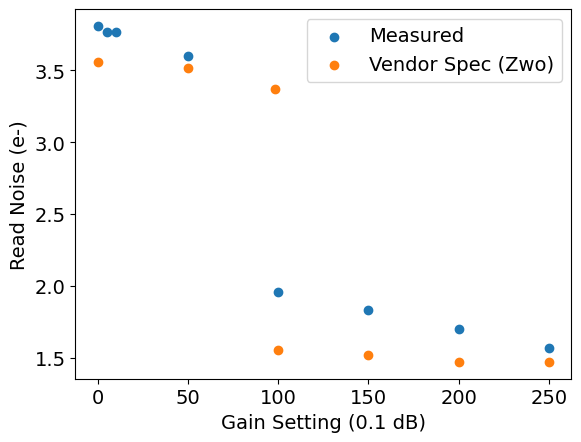

In [ ]:
imx455_gain_settings = np.array([0, 5, 10, 50, 100, 150, 200, 250])
imx455_read_noise_values = np.array([3.81, 3.77, 3.77, 3.60, 1.96, 1.83, 1.70, 1.57])
imx455_zwo_gain_settings = np.array([0, 50, 98, 100, 150, 200, 250])
imx455_zwo_read_noise_values = np.array([3.56, 3.52, 3.37, 1.55, 1.52, 1.47, 1.47])
plt.scatter(imx455_gain_settings, imx455_read_noise_values, label='Measured')
plt.scatter(imx455_zwo_gain_settings, imx455_zwo_read_noise_values, label='Vendor Spec (Zwo)')
plt.legend()
plt.xlabel('Gain Setting (0.1 dB)')
plt.ylabel('Read Noise (e-)')
plt.show()

25.426475955393272


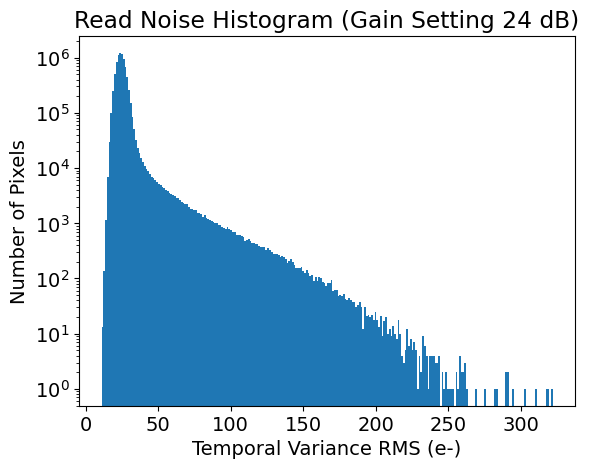

In [ ]:
# Make a read noise histogram
dir0 = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX487/Nonuniformity/Dark Images 1 ms'
# Print files
files = os.listdir(dir0)
def get_var_img(dir):
    '''Returns the temporal variance of the sequence'''
    files = os.listdir(dir)
    files = [file for file in files if file.endswith('.fits')]
    img_0 = fits.getdata(dir + '/' + files[0])
    avg_img = np.zeros_like(img_0)
    for file in files:
        avg_img += fits.getdata(dir + '/' + file)
    avg_img = avg_img / len(files)
    var_img = np.zeros_like(img_0).astype(float)
    for file in files:
        var_img += (fits.getdata(dir + '/' + file) - avg_img) ** 2
    return var_img / (len(files) - 1)

var_img = get_var_img(dir0)
std_img = np.sqrt(var_img) / 0.406
print(np.mean(std_img))
# Plot histogram
plt.hist(std_img.flatten(), bins=256)
plt.yscale('log')
plt.xlabel('Temporal Variance RMS (e-)')
plt.ylabel('Number of Pixels')
plt.title('Read Noise Histogram (Gain Setting 24 dB)')
plt.show()

In [ ]:
subdir = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX487/IMX487_Read_Noise/'
gain_setting_list = np.arange(0, 26, 2)
read_noise_list = np.zeros_like(gain_setting_list).astype(float)
for i, gain_setting in enumerate(gain_setting_list):
    dir = subdir + 'Gain ' + str(gain_setting) + ' dB'
    gain = 10 ** (gain_setting/20) * 0.406
    read_noise_list[i] = read_noise(dir, gain=gain)

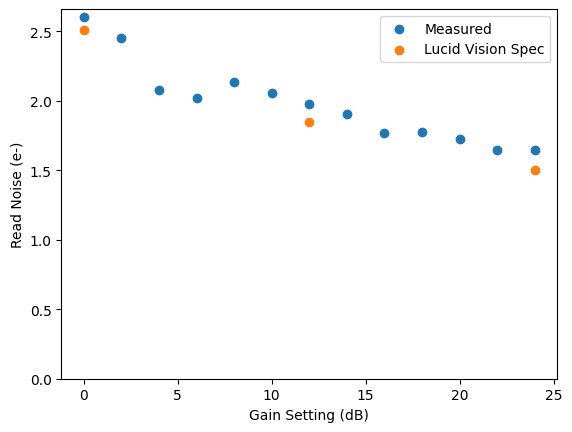

In [ ]:
plt.scatter(gain_setting_list, read_noise_list, label='Measured')
plt.scatter(lucid_gain_values, lucid_read_noise_values, label='Lucid Vision Spec')
plt.xlabel('Gain Setting (dB)')
plt.ylabel('Read Noise (e-)')
plt.legend()
plt.ylim(bottom=0)
plt.show()

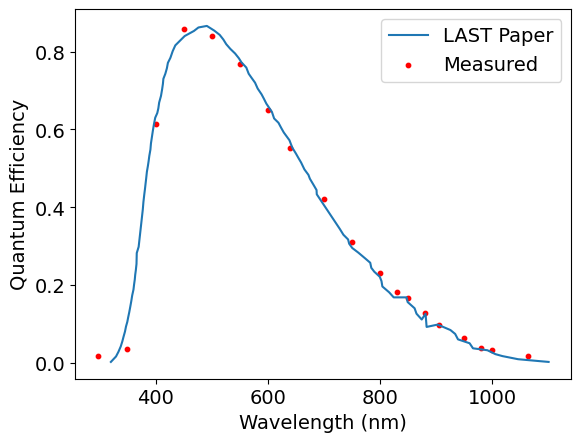

In [13]:
# Open IMX455 QE data from LAST
data_folder = '/Users/layden/Documents/TESS/Image-Sensor-Testing/data/'
imx455_QE_LAST = np.genfromtxt(data_folder + 'IMX455_QE_LAST.csv', delimiter=',')
imx487_QE = np.genfromtxt(data_folder + 'IMX487_QE.csv', delimiter=',')
meas_wave = np.array([297, 350, 400, 450, 500, 550, 600, 640, 700, 750, 800, 830, 850, 880, 905, 950, 980, 1000, 1064])
meas_QE = np.array([0.016, 0.034, 0.614, 0.857, 0.841, 0.768, 0.650, 0.551, 0.422, 0.311, 0.230, 0.182, 0.167, 0.128, 0.096, 0.063, 0.039, 0.032, 0.018])
# meas_QE_err = np.array([0.0004, 0.0009, 0.012, 0.012, 0.012, 0.008, 0.007])
plt.plot(imx455_QE_LAST[:, 0], imx455_QE_LAST[:, 1], label='LAST Paper')
# plt.errorbar(meas_wave, meas_QE, yerr=meas_QE_err, fmt='o', color='red', markersize=3, label='Measured')
plt.scatter(meas_wave, meas_QE, color='red', s=10, label='Measured')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.legend()
plt.show()

3.2017252981060627 0.91007904953512


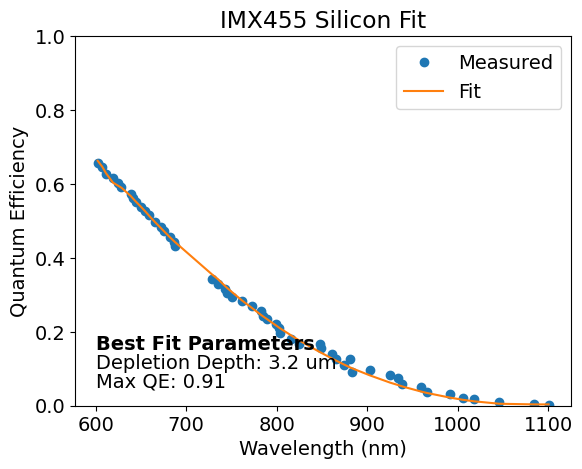

7.683702266391391 0.4610527876828973


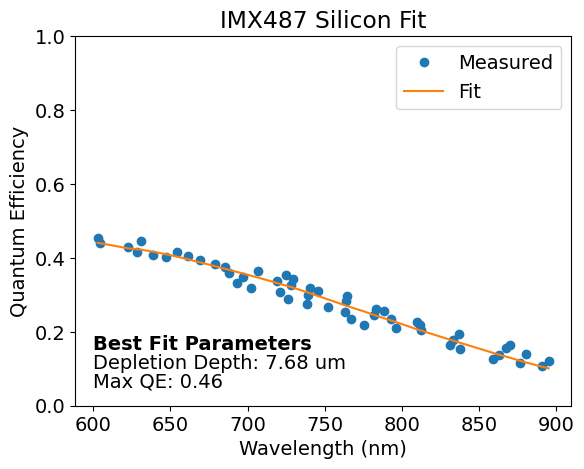

In [14]:
# Fit the quantum efficiency curve to a silicon model
# Load silicon absorption data. It's one level above this file
data_folder = '/Users/layden/Documents/TESS/Image-Sensor-Testing/data/'
# x axis is wavelength in nm, y axis is absorption length in um
silicon_abs = np.genfromtxt(data_folder + 'silicon_absorption.csv', delimiter=',')
def theoretical_qe(wavelength, depletion_depth, max_qe=1):
    '''Returns the theoretical quantum efficiency of silicon at a given wavelength'''
    abs_length = np.interp(wavelength, silicon_abs[:, 0], silicon_abs[:, 1])
    return (1 - np.exp(-depletion_depth / abs_length)) * max_qe

def fit_absorption(wavelength_arr, qe_arr):
    '''Using measured QE data, fit to find the depletion depth and maximum QE.'''
    popt, pcov = scipy.optimize.curve_fit(theoretical_qe, wavelength_arr, qe_arr, p0=[10, 1])
    return popt


wavelengths_last = imx455_QE_LAST[imx455_QE_LAST[:, 0] > 600, 0]
qe_last = imx455_QE_LAST[imx455_QE_LAST[:, 0] > 600, 1]
depth, qe_max = fit_absorption(wavelengths_last, qe_last)
print(depth, qe_max)
# Plot the fit
plt.plot(wavelengths_last, qe_last, 'o', label='Measured')
plt.plot(wavelengths_last, theoretical_qe(wavelengths_last, depth, max_qe=qe_max), label='Fit')
plt.text(600, 0.15, 'Best Fit Parameters', weight='bold')
plt.text(600, 0.1, 'Depletion Depth: ' + str(round(depth, 2)) + ' um')
plt.text(600, 0.05, 'Max QE: ' + str(round(qe_max, 2)))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.ylim([0,1])
plt.legend()
plt.title('IMX455 Silicon Fit')
plt.show()

wavelengths_imx487 = imx487_QE[imx487_QE[:, 0] > 600, 0]
qe_imx487 = imx487_QE[imx487_QE[:, 0] > 600, 1]
depth_imx487, qe_max_imx487 = fit_absorption(wavelengths_imx487, qe_imx487)
print(depth_imx487, qe_max_imx487)
# Plot the fit
plt.plot(wavelengths_imx487, qe_imx487, 'o', label='Measured')
plt.plot(wavelengths_imx487, theoretical_qe(wavelengths_imx487, depth_imx487, max_qe=qe_max_imx487), label='Fit')
plt.text(600, 0.15, 'Best Fit Parameters', weight='bold')
plt.text(600, 0.1, 'Depletion Depth: ' + str(round(depth_imx487, 2)) + ' um')
plt.text(600, 0.05, 'Max QE: ' + str(round(qe_max_imx487, 2)))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.ylim([0,1])
plt.legend()
plt.title('IMX487 Silicon Fit')
plt.show()


In [ ]:
# Given an image, plot the horizontal and vertical profiles    
def plot_profiles(img_file):
    '''Plot the horizontal and vertical profiles described in EMVA 1288 standard.'''
    # Check if it's a .fits file
    if not img_file.endswith('.fits'):
        exception_str = 'File must be a .fits file'
        raise Exception(exception_str)
    img = fits.getdata(img_file)
    M = img.shape[0]
    N = img.shape[1]
    middle_horiz = img[M//2, :]
    middle_vert = img[:, N//2]
    mean_horiz = np.mean(img, axis=0)
    mean_vert = np.mean(img, axis=1)
    nonuniformity_horiz = (np.max(mean_horiz) - np.min(mean_horiz)) / np.mean(mean_horiz)
    nonuniformity_vert = (np.max(mean_vert) - np.min(mean_vert)) / np.mean(mean_vert)
    print('Maximum nonuniformity in columns: ' + str(round(nonuniformity_horiz * 100, 2)) + '%')
    print('Maximum nonuniformity in rows: ' + str(round(nonuniformity_vert * 100, 2)) + '%')
    # Find the nonuniformity from the source by dividing the mean of the central 10 rows by the mean of the leftmost 10 rows
    source_nonuniformity_left = 1 - np.mean(mean_vert[M//2 - 5:M//2 + 5]) / np.mean(mean_vert[:10])
    print("Source Nonuniformity from Left to Center: " + str(round(source_nonuniformity_left * 100, 2)) + '%')
    source_nonuniformity_right = 1 - np.mean(mean_vert[M//2 - 5:M//2 + 5]) / np.mean(mean_vert[-10:])
    print("Source Nonuniformity from Right to Center: " + str(round(source_nonuniformity_right * 100, 2)) + '%')
    source_nonuniformity_top = 1 - np.mean(mean_horiz[N//2 - 5:N//2 + 5]) / np.mean(mean_horiz[:10])
    print("Source Nonuniformity from Top to Center: " + str(round(source_nonuniformity_top * 100, 2)) + '%')
    source_nonuniformity_bottom = 1 - np.mean(mean_horiz[N//2 - 5:N//2 + 5]) / np.mean(mean_horiz[-10:])
    print("Source Nonuniformity from Bottom to Center: " + str(round(source_nonuniformity_bottom * 100, 2)) + '%')

    min_horiz = np.min(img, axis=0)
    min_vert = np.min(img, axis=1)
    max_horiz = np.max(img, axis=0)
    max_vert = np.max(img, axis=1)
    lower_lim = np.mean(img) * 0.9
    upper_lim = np.mean(img) * 1.1
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)
    ax1.plot(middle_horiz, label='Middle', linewidth=0.5)
    ax1.plot(mean_horiz, label='Mean', linewidth=0.5)
    # ax1.plot(min_horiz, label='Min', linewidth=0.5)
    # ax1.plot(max_horiz, label='Max', linewidth=0.5)
    ax1.set_xlabel('Column Number')
    ax1.set_ylabel('Dark Signal (ADU)')
    leg1 = ax1.legend(loc='lower left', ncol=2)
    for legobj in leg1.legendHandles:
        legobj.set_linewidth(2.0)
    ax1.set_ylim(lower_lim, upper_lim)
    ax2.plot(middle_vert, label='Middle', linewidth=0.5)
    ax2.plot(mean_vert, label='Mean', linewidth=0.5)
    # ax2.plot(min_vert, label='Min', linewidth=0.5)
    # ax2.plot(max_vert, label='Max', linewidth=0.5)
    ax2.set_xlabel('Row Number')
    leg2 = ax2.legend(loc='lower left', ncol=2)
    for legobj in leg2.legendHandles:
        legobj.set_linewidth(2.0)
    ax2.set_ylim(lower_lim, upper_lim)
    plt.show()

Maximum nonuniformity in columns: 1.15%
Maximum nonuniformity in rows: 1.28%
Source Nonuniformity from Left to Center: -0.5%
Source Nonuniformity from Right to Center: -0.56%
Source Nonuniformity from Top to Center: -0.17%
Source Nonuniformity from Bottom to Center: -0.47%


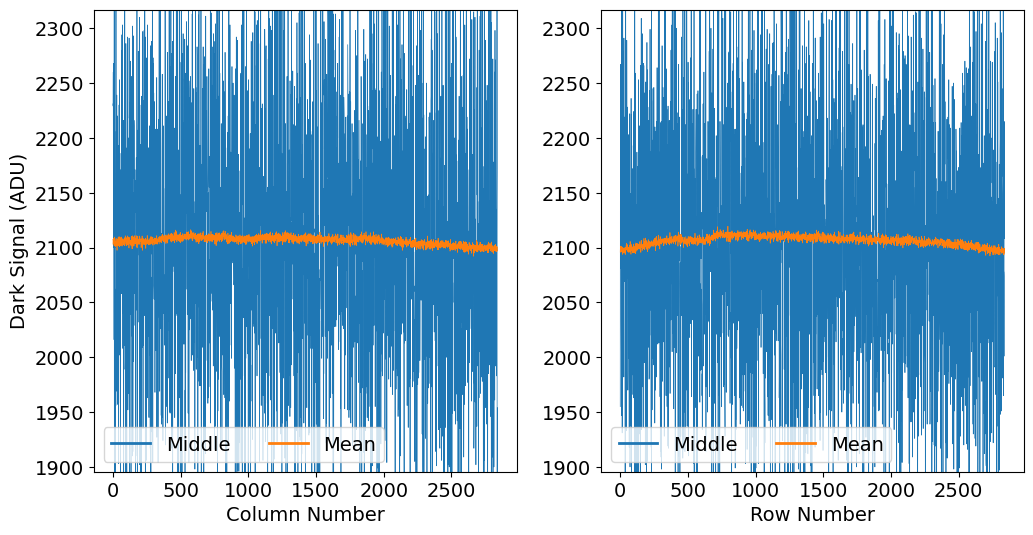

In [ ]:
img_dir = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX455/Photon Transfer/Gray Images/'
img_file = img_dir + '40000ms_00002_2_5_2024T10_51_50.fits'
img_dir = '/Users/layden/Library/CloudStorage/Box-Box/clayden7/TESS-GEO Sensor Testing/IMX487/Nonuniformity/Gray Images/'
img_file = img_dir + '1840.00ms_1.fits'
plot_profiles(img_file)

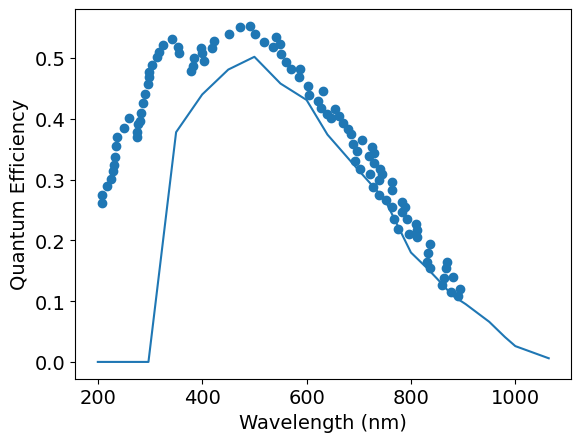

In [20]:
wavelengths = [200, 250, 297, 350, 400, 450, 500, 550, 600, 640, 700, 750, 800, 830, 850, 880, 905, 950, 980, 1000, 1064]
imx487_QE_meas = [0, 0, 0, 0.378, 0.440, 0.481, 0.502, 0.458, 0.431, 0.374, 0.315, 0.267, 0.180, 0.155, 0.137, 0.109, 0.095, 0.066, 0.041, 0.026, 0.006]
plt.plot(wavelengths, imx487_QE_meas)
plt.scatter(imx487_QE[:, 0], imx487_QE[:, 1])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.show()

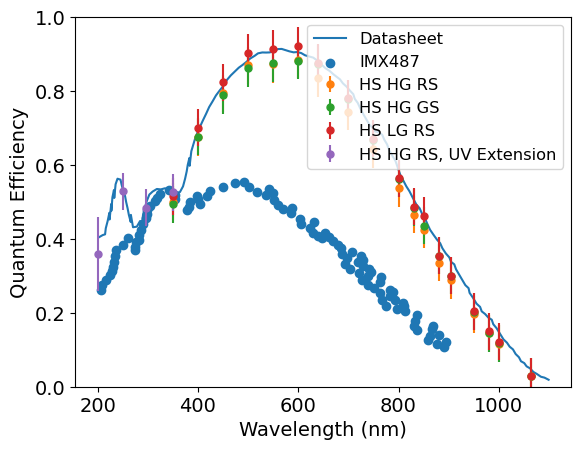

In [24]:
# Read QE from data
data_folder = '/Users/layden/Documents/TESS/Image-Sensor-Testing/data/'
cosmos_qe = np.genfromtxt(data_folder + 'cosmos_qe_datasheet.csv', delimiter=',')
qe_wavelengths = [350, 400, 450, 500, 550, 600, 640, 700, 750, 800, 830, 850, 880, 905, 950, 980, 1000, 1064]
cosmos_qe_HS_HG_RS = [0.500, 0.675, 0.794, 0.870, 0.872, 0.885, 0.834, 0.744, 0.643, 0.537, 0.465, 0.424, 0.336, 0.288, 0.196, 0.145, 0.116, 0.029]
cosmos_qe_HS_HG_GS = [0.494, 0.676, 0.789, 0.862, 0.875, 0.882, 0.874, 0.779, 0.668, 0.562, 0.484, 0.436, 0.354, 0.300, 0.203, 0.144, 0.117, 0.028]
cosmos_qe_HS_LG_RS = [0.515, 0.701, 0.824, 0.904, 0.914, 0.923, 0.877, 0.781, 0.671, 0.564, 0.487, 0.462, 0.354, 0.300, 0.204, 0.150, 0.122, 0.029]
cosmos_qe_uv_wave = [200, 250, 297, 350]
cosmos_qe_uv = [0.358, 0.529, 0.484, 0.526]
cosmos_qe_uv_errorbars = [0.1, 0.05, 0.05, 0.05]
plt.plot(cosmos_qe[:, 0], cosmos_qe[:, 1], label='Datasheet')
plt.scatter(imx487_QE[:, 0], imx487_QE[:, 1], label='IMX487')
plt.errorbar(qe_wavelengths, cosmos_qe_HS_HG_RS, 0.05, marker='o', markersize=5., ls='None', label='HS HG RS') # Do better error analysis
plt.errorbar(qe_wavelengths, cosmos_qe_HS_HG_GS, 0.05, marker='o', markersize=5., ls='None', label='HS HG GS')
plt.errorbar(qe_wavelengths, cosmos_qe_HS_LG_RS, 0.05, marker='o', markersize=5., ls='None', label='HS LG RS')
plt.errorbar(cosmos_qe_uv_wave, cosmos_qe_uv, cosmos_qe_uv_errorbars, marker='o', markersize=5., ls='None', label='HS HG RS, UV Extension')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.ylim(0, 1)
plt.legend(fontsize='small', loc='upper right')
plt.show()

In [18]:
# Get wavelength values greater than 600
fit_wavelengths = qe_wavelengths[3:]
fit_qe = cosmos_qe_HS_HG_RS[3:]
depth_cosmos, qe_max_cosmos = fit_absorption(fit_wavelengths, fit_qe)
print(depth_cosmos, qe_max_cosmos)

12.349798750226398 0.8602622073718627
